In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [81]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
import xml.etree.ElementTree as ET

In [76]:
XML_PATH = os.path.join( "annotations")
IMG_PATH = os.path.join( "path")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [82]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [94]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,new_data0.jpeg,rouille,"[448, 115, 751, 238]",annotations\new_data0.xml,path\new_data0.jpeg
1,new_data0.jpeg,rouille,"[478, 663, 568, 834]",annotations\new_data0.xml,path\new_data0.jpeg
2,new_data0.jpeg,rouille,"[662, 717, 841, 1002]",annotations\new_data0.xml,path\new_data0.jpeg
3,new_data0.jpeg,rouille,"[528, 776, 636, 1125]",annotations\new_data0.xml,path\new_data0.jpeg
4,new_data0.jpeg,rouille,"[52, 517, 420, 635]",annotations\new_data0.xml,path\new_data0.jpeg


In [95]:
df['names'].value_counts()

polystigma           554
rouille              499
coryneum             434
acariens             343
othyorinques         207
faux tigre           166
scolytes             143
chancre fusicocum    118
Name: names, dtype: int64

In [96]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

C:\Users\zakaria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [97]:
df.head()

,image_id,names,xml_path,img_path,xmin,ymin,xmax,ymax
0,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,448.0,115.0,751.0,238.0
1,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,478.0,663.0,568.0,834.0
2,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,662.0,717.0,841.0,1002.0
3,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,528.0,776.0,636.0,1125.0
4,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,52.0,517.0,420.0,635.0


In [98]:
a=df.copy()
a=pd.get_dummies(a['names'])
df1=pd.concat([df, a], axis=1)
df1.head()

,image_id,names,xml_path,img_path,xmin,ymin,xmax,ymax,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,rouille,scolytes
0,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,448.0,115.0,751.0,238.0,0,0,0,0,0,0,1,0
1,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,478.0,663.0,568.0,834.0,0,0,0,0,0,0,1,0
2,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,662.0,717.0,841.0,1002.0,0,0,0,0,0,0,1,0
3,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,528.0,776.0,636.0,1125.0,0,0,0,0,0,0,1,0
4,new_data0.jpeg,rouille,annotations\new_data0.xml,path\new_data0.jpeg,52.0,517.0,420.0,635.0,0,0,0,0,0,0,1,0


In [99]:
df1.drop(columns='names', inplace=True)

df1.shape

(2464, 15)

In [101]:
data=df1[['acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille', 'scolytes']]

In [102]:
data.columns

Index(['acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille', 'scolytes'],
      dtype='object')

<AxesSubplot:ylabel='None'>

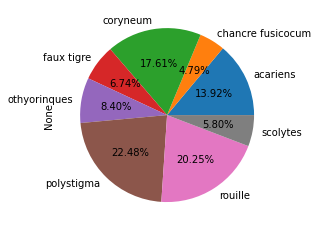

In [103]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [104]:
img_size={'height': 960,
         'width': 1280 }

In [105]:
data.shape

(2464, 8)

In [107]:
path='path/'
data_path=df1['img_path']

(1280, 958, 3)


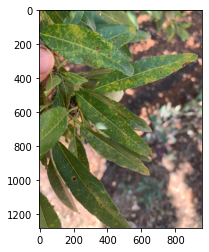

In [61]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [109]:
data_path

0        path\new_data0.jpeg
1        path\new_data0.jpeg
2        path\new_data0.jpeg
3        path\new_data0.jpeg
4        path\new_data0.jpeg
                ...         
2459    path\new_data98.jpeg
2460    path\new_data98.jpeg
2461    path\new_data99.jpeg
2462    path\new_data99.jpeg
2463    path\new_data99.jpeg
Name: img_path, Length: 2464, dtype: object

In [125]:
data_labels = df1.loc[:, ['xmin','ymin','xmax','ymax','acariens', 'chancre fusicocum', 'faux tigre','scolytes', 'polystigma','coryneum', 'rouille']].values

In [126]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [127]:
len(test_paths)

493

In [128]:
IMG_SIZE=299
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label


In [129]:
BATCH_SIZE = 16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [130]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [124]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('xceptions')

In [131]:
Dense_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [135]:
x = Dense_net.get_layer("global_average_pooling2d_3").output

#x = tf.keras.layers.Dense(1024, activation='softmax')(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [136]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // BATCH_SIZE,
    epochs=80,
    validation_data=test_dataset
    )

Epoch 1/80
154/154 [==============================] - 117s 675ms/step - loss: 3190.3311 - accuracy: 0.4513 - val_loss: 3049.9089 - val_accuracy: 0.7079
Epoch 2/80
154/154 [==============================] - 105s 681ms/step - loss: 3405.6655 - accuracy: 0.4972 - val_loss: 3863.4604 - val_accuracy: 0.2921
Epoch 3/80
154/154 [==============================] - 106s 688ms/step - loss: 4769.7441 - accuracy: 0.5028 - val_loss: 5462.7344 - val_accuracy: 0.7079
Epoch 4/80
154/154 [==============================] - 106s 686ms/step - loss: 6937.7158 - accuracy: 0.4412 - val_loss: 10391.2842 - val_accuracy: 0.2921
Epoch 5/80
154/154 [==============================] - 106s 687ms/step - loss: 11270.2764 - accuracy: 0.4326 - val_loss: 12725.9697 - val_accuracy: 0.7079
Epoch 6/80
154/154 [==============================] - 105s 685ms/step - loss: 15581.6562 - accuracy: 0.4712 - val_loss: 143505.6562 - val_accuracy: 0.2921
Epoch 7/80
154/154 [==============================] - 105s 683ms/step - loss: 2936

In [137]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

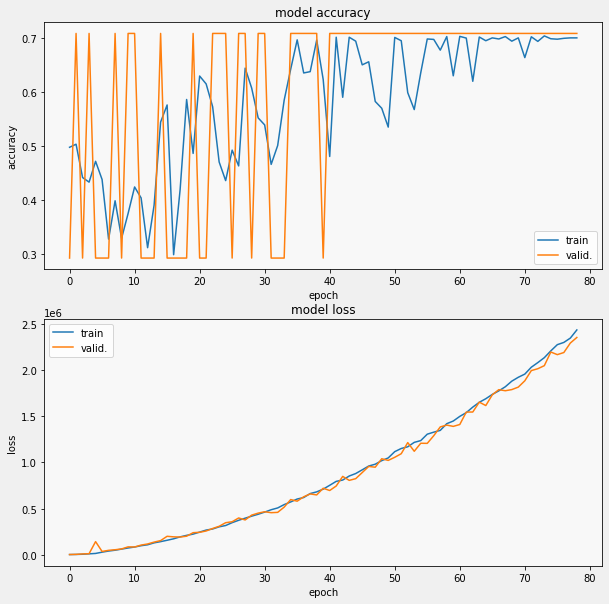

In [138]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [139]:
import pickle
with open('training_log/first_try_segmentation.pkl', 'wb') as output:
        pickle.dump(history.history, output)